In [1]:
# Importing the required libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import clear_output,display

from sklearn.model_selection import cross_val_score,GridSearchCV,RandomizedSearchCV
from sklearn.metrics import mean_squared_log_error,mean_squared_error
from sklearn.linear_model import LinearRegression,Lasso,Ridge

from sklearn.preprocessing import StandardScaler,MinMaxScaler

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor,BaggingRegressor

from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

from sklearn.neighbors import KNeighborsRegressor

import warnings
warnings.filterwarnings('ignore')

In [2]:
# importing the train and test datasets

tr=pd.read_csv("train.csv")
test=pd.read_csv("test.csv")
sample_sub=pd.read_csv("sample_submission.csv")

In [3]:
tr=tr[["ID","Day_No","Sales"]]
tr

,ID,Day_No,Sales
0,1,1,81
1,2,2,79
2,3,3,75
3,4,4,80
4,5,5,41
...,...,...,...
512082,548023,878,114
512083,548024,879,145
512084,548025,880,167
512085,548026,881,107


In [4]:
train=tr.groupby("Day_No").sum()["Sales"]
train

Day_No
1       78603
2       67389
3       61725
4       64464
5       59094
        ...  
878     67278
879     80955
880     74450
881     58999
882    114140
Name: Sales, Length: 882, dtype: int64

In [5]:
train,val=train[train.index<=822],train[train.index>822]

In [23]:
train

Day_No
1       78603
2       67389
3       61725
4       64464
5       59094
        ...  
818     55825
819    121131
820    109930
821    108359
822    111420
Name: Sales, Length: 822, dtype: int64

In [24]:
val

Day_No
823     72473
824     92689
825     86765
826     19841
827     76109
828     65411
829     63288
830     64181
831     63316
832     53589
833    107470
834     88302
835     77462
836     81115
837     84558
838     64261
839     73982
840     63139
841     57717
842     58373
843     59251
844     61208
845     62124
846     53817
847    103197
848     90322
849     92394
850    110168
851     65563
852     86302
853     77250
854    106799
855     84955
856     84031
857     82790
858     83976
859     70517
860     77046
861     64724
862     64257
863     79071
864     56357
865     83557
866     63641
867     54667
868    103094
869     86248
870     80920
871     79551
872     80478
873     66427
874     74019
875     63190
876     75119
877     66405
878     67278
879     80955
880     74450
881     58999
882    114140
Name: Sales, dtype: int64

## Stationarity test

In [25]:
# dickey fuller, KPSS
from statsmodels.tsa.stattools import adfuller, kpss

In [26]:
def adf_test(timeseries):
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput=pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [27]:
adf_test(train)

Results of Dickey-Fuller Test:
Test Statistic                  -4.465763
p-value                          0.000227
#Lags Used                      20.000000
Number of Observations Used    801.000000
Critical Value (1%)             -3.438540
Critical Value (5%)             -2.865155
Critical Value (10%)            -2.568695
dtype: float64


**Our series is Stationary**

In [28]:
def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c')
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)

In [29]:
kpss_test(train)

Results of KPSS Test:
Test Statistic            0.199919
p-value                   0.100000
Lags Used                21.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1843: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1876: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(warn_msg.format(direction="greater"), InterpolationWarning)


## ACF and PACF plot

In [30]:
from statsmodels.tsa.stattools import acf, pacf 

In [32]:
lag_acf = acf(train, nlags=25) 
lag_pacf = pacf(train, nlags=25)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:666: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning,


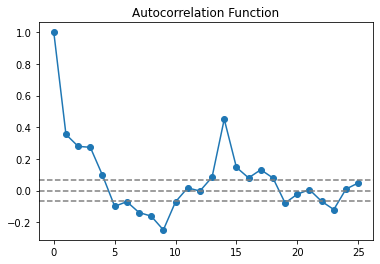

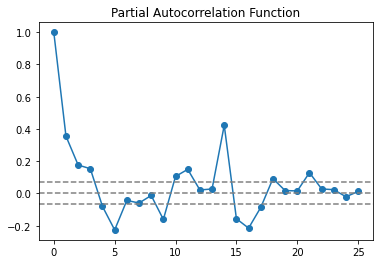

In [33]:
plt.plot(lag_acf,  marker='o') 
plt.axhline(y=0,linestyle='--',color='gray') 
plt.axhline(y=-1.96/np.sqrt(len(train)),linestyle='--',color='gray') 
plt.axhline(y=1.96/np.sqrt(len(train)),linestyle='--',color='gray') 
plt.title('Autocorrelation Function') 
plt.show() 

plt.plot(lag_pacf, marker='o') 
plt.axhline(y=0,linestyle='--',color='gray') 
plt.axhline(y=-1.96/np.sqrt(len(train)),linestyle='--',color='gray') 
plt.axhline(y=1.96/np.sqrt(len(train)),linestyle='--',color='gray') 
plt.title('Partial Autocorrelation Function') 
plt.show()

## AR Model

In [117]:
from statsmodels.tsa.arima_model import ARIMA

In [118]:
# fit AR model
model = ARIMA(train, order=(6,0,10))
model_fit= model.fit(disp=0)

In [119]:
output = model_fit.forecast(len(val))
pred_valid = (pd.DataFrame(output[0])).values

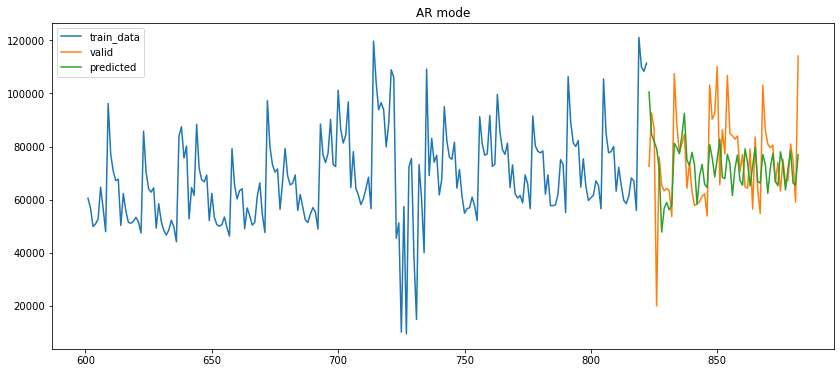

In [120]:
plt.figure(figsize=(14,6))

plt.plot(train[600:].index, train[600:], label='train_data')
plt.plot(val.index, val, label='valid')
plt.plot(val.index, pred_valid, label='predicted')

plt.legend(loc='best')
plt.title("AR mode")
plt.show()

In [121]:
# calculating RMSE 
from math import sqrt
rmse = sqrt(mean_squared_error(val, pred_valid))
print('The RMSE value for AR is', rmse)

The RMSE value for AR is 16179.368380266495


In [122]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  Sales   No. Observations:                  822
Model:                    ARMA(6, 10)   Log Likelihood               -8962.557
Method:                       css-mle   S.D. of innovations          13015.404
Date:                Mon, 19 Oct 2020   AIC                          17961.114
Time:                        15:24:29   BIC                          18045.926
Sample:                             0   HQIC                         17993.653
                                                                              
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         6.979e+04   1377.382     50.671      0.000    6.71e+04    7.25e+04
ar.L1.Sales      1.1927    2.5e-05   4.78e+04      0.000       1.193       1.193
ar.L2.Sales     -0.1863        nan        nan        nan         nan         nan
ar.L3.Sales      0.1677        nan        nan        nan         nan         nan
ar.L4.Sales      0.1870      0.001    298.953      0.000       0.186       0.188
ar.L5.Sales     -1.1642   6.86e-06   -1.7e+05      0.000      -1.164      -1.164
ar.L6.Sales      0.7723   3.79e-05   2.04e+04      0.000       0.772       0.772
ma.L1.Sales     -0.9501      0.033    -28.552      0.000      -1.015      -0.885
ma.L2.Sales      0.2298      0.045      5.121      0.000       0.142       0.318
ma.L3.Sales     -0.2496      0.044     -5.690      0.000      -0.336      -0.164
ma.L4.Sales     -0.4104      0.047     -8.642      0.000      -0.503      -0.317
ma.L5.Sales      1.2197      0.041     29.442      0.000       1.138       1.301
ma.L6.Sales     -0.6644      0.043    -15.481      0.000      -0.749      -0.580
ma.L7.Sales     -0.0839      0.046     -1.816      0.069      -0.175       0.007
ma.L8.Sales      0.0306      0.044      0.693      0.488      -0.056       0.117
ma.L9.Sales     -0.3282      0.045     -7.276      0.000      -0.417      -0.240
ma.L10.Sales     0.3017      0.034      8.977      0.000       0.236       0.368
                                    Roots                                     
==============================================================================
                   Real          Imaginary           Modulus         Frequency
------------------------------------------------------------------------------
AR.1            -1.0416           -0.0000j            1.0416           -0.5000
AR.2            -0.2224           -0.9750j            1.0000           -0.2857
AR.3            -0.2224           +0.9750j            1.0000            0.2857
AR.4             0.9805           -0.4921j            1.0971           -0.0740
AR.5             0.9805           +0.4921j            1.0971            0.0740
AR.6             1.0328           -0.0000j            1.0328           -0.0000
MA.1            -1.1466           -0.1476j            1.1561           -0.4796
MA.2            -1.1466           +0.1476j            1.1561            0.4796
MA.3            -0.2272           -0.9851j            1.0110           -0.2861
MA.4            -0.2272           +0.9851j            1.0110            0.2861
MA.5            -0.0990           -1.2589j            1.2627           -0.2625
MA.6            -0.0990           +1.2589j            1.2627            0.2625
MA.7             0.8482           -0.6316j            1.0576           -0.1019
MA.8             0.8482           +0.6316j            1.0576            0.1019
MA.9             1.0971           -0.0000j            1.0971           -0.0000
MA.10            1.2402           -0.0000j            1.2402           -0.0000
-----------------------------------------

## Seasonal ACF and PACF plot

In [30]:
from statsmodels.tsa.stattools import acf, pacf 

In [105]:
diff_7=train-train.shift(7)
diff_7.dropna()

Day_No
8       6213.0
9       8208.0
10     13815.0
11     13839.0
12       428.0
        ...   
818   -16315.0
819    55632.0
820    50211.0
821    49903.0
822    50101.0
Name: Sales, Length: 815, dtype: float64

In [108]:
lag_acf = acf(diff_7.dropna(), nlags=25) 
lag_pacf = pacf(diff_7.dropna(), nlags=25)

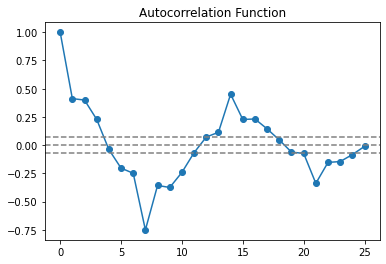

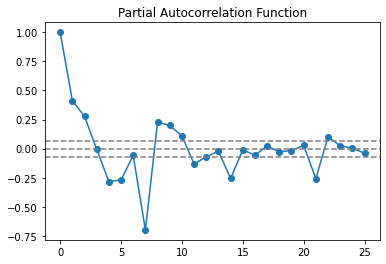

In [109]:
plt.plot(lag_acf,  marker='o') 
plt.axhline(y=0,linestyle='--',color='gray') 
plt.axhline(y=-1.96/np.sqrt(len(diff_7.dropna())),linestyle='--',color='gray') 
plt.axhline(y=1.96/np.sqrt(len(diff_7.dropna())),linestyle='--',color='gray') 
plt.title('Autocorrelation Function') 
plt.show() 

plt.plot(lag_pacf, marker='o') 
plt.axhline(y=0,linestyle='--',color='gray') 
plt.axhline(y=-1.96/np.sqrt(len(diff_7.dropna())),linestyle='--',color='gray') 
plt.axhline(y=1.96/np.sqrt(len(diff_7.dropna())),linestyle='--',color='gray') 
plt.title('Partial Autocorrelation Function') 
plt.show()

## SARIMA

In [93]:
from statsmodels.tsa.statespace import sarimax

In [116]:
model = sarimax.SARIMAX(train, seasonal_order=(3,0,4,7), order=(6,0,10))
fit1 = model.fit()

valid_pred = fit1.predict(start=823, end=882, dynamic=True)

ValueError: Invalid model: moving average lag(s) {7} are in both the seasonal and non-seasonal moving average components.

In [123]:
# val_User_Traffic_MA=[]

# for i in range(1,601):
    
# #     tr,valid=train[(train.Day_No<=822)&(train.Course_ID==i)],train[(train.Day_No>822)&(train.Course_ID==i)]
#     tr=train[train.Course_ID==i]
    
#     for j in range(823,883):
#         df=tr.loc[(tr.Day_No>=j-14)&(tr.Day_No<j)]
#         val_User_Traffic_MA.append(df["User_Traffic"].mean())

In [126]:
val.loc[:,'User_Traffic']=val_User_Traffic_MA

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [128]:
# mean_UT=train.groupby(["Course_ID","Week_No","Short_Promotion","Day_of_2_Weeks"])["User_Traffic"].mean().to_frame()
# mean_UT.reset_index(inplace=True)
# mean_UT["Group_Traffic"]=mean_UT["User_Traffic"]
# mean_UT.drop(columns="User_Traffic",inplace=True)
# mean_UT

In [129]:
# train=train.merge(mean_UT,how="left")
# test=test.merge(mean_UT,how="left")

In [130]:
# train.drop(columns=["ID","User_Traffic","Day_No"],inplace=True)
# test.drop(columns=["ID","Day_No"],inplace=True)

In [131]:
# train["Sales"]=np.log1p(train["Sales"])

traaiin["Sales"]=np.log1p(traaiin["Sales"])
traaiin["User_Traffic"]=np.log1p(traaiin["User_Traffic"])


val["Sales"]=np.log1p(val["Sales"])
val["User_Traffic"]=np.log1p(val["User_Traffic"])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

In [132]:
def export_submission(predictions,filename="Sample.csv"):
    
    ss=sample_sub.copy()
    ss["Sales"]=np.expm1(predictions)
    ss.to_csv(f"{filename}.csv",index=False)

In [133]:
train.dtypes

ID                      int64
Day_No                  int64
Course_ID               int64
Course_Domain          object
Course_Type            object
Short_Promotion         int64
Public_Holiday          int64
Long_Promotion          int64
User_Traffic            int64
Competition_Metric    float64
Sales                   int64
Day_of_2_Weeks          int64
Week_No                 int64
Year_No                 int32
dtype: object

In [134]:
train.groupby("Course_Domain").mean()["Sales"]

Course_Domain
Business                186.592971
Development             120.016391
Finance & Accounting    124.520231
Software Marketing      118.654665
Name: Sales, dtype: float64

In [135]:
train.groupby("Course_Type").mean()["Sales"]

Course_Type
Course     113.411236
Degree     184.061224
Program    128.246482
Name: Sales, dtype: float64

In [136]:
traaiin["Course_Domain"]=traaiin["Course_Domain"].map({'Business':0,"Development":1,"Finance & Accounting":2,"Software Marketing":3})
val["Course_Domain"]=val["Course_Domain"].map({'Business':0,"Development":1,"Finance & Accounting":2,"Software Marketing":3})

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [137]:
traaiin["Course_Type"]=traaiin["Course_Type"].map({'Course':0,"Degree":1,"Program":2})
val["Course_Type"]=val["Course_Type"].map({'Course':0,"Degree":1,"Program":2})

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [138]:
traaiin

,ID,Day_No,Course_ID,Course_Domain,Course_Type,Short_Promotion,Public_Holiday,Long_Promotion,User_Traffic,Competition_Metric,Sales,Day_of_2_Weeks,Week_No,Year_No
0,1,1,1,1,0,0,1,1,9.306105,0.007,4.406719,1,1,1
1,2,2,1,1,0,0,0,1,9.521568,0.007,4.382027,2,1,1
2,3,3,1,1,0,0,0,1,9.363576,0.007,4.330733,3,1,1
3,4,4,1,1,0,0,0,1,9.397235,0.007,4.394449,4,1,1
4,5,5,1,1,0,0,0,1,8.825413,0.007,3.737670,5,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
512022,547963,818,600,3,2,0,0,1,8.941807,0.070,4.418841,6,13,3
512023,547964,819,600,3,2,1,0,1,9.538348,0.070,5.351858,7,13,3
512024,547965,820,600,3,2,1,0,1,9.367173,0.070,5.099866,8,14,3
512025,547966,821,600,3,2,1,0,1,9.438193,0.070,5.252273,9,14,3


In [139]:
val

,ID,Day_No,Course_ID,Course_Domain,Course_Type,Short_Promotion,Public_Holiday,Long_Promotion,User_Traffic,Competition_Metric,Sales,Day_of_2_Weeks,Week_No,Year_No
822,823,823,1,1,0,1,1,1,9.384336,0.007,4.143135,11,14,3
823,824,824,1,1,0,0,0,1,9.370118,0.007,4.394449,12,14,3
824,825,825,1,1,0,0,0,1,9.387733,0.007,4.418841,13,14,3
825,826,826,1,1,0,0,1,1,9.385595,0.007,2.772589,14,14,3
826,827,827,1,1,0,0,0,1,9.334724,0.007,4.418841,1,15,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
512082,548023,878,600,3,2,0,0,1,9.229211,0.070,4.744932,10,22,3
512083,548024,879,600,3,2,0,0,1,9.234789,0.070,4.983607,11,22,3
512084,548025,880,600,3,2,0,0,1,9.228033,0.070,5.123964,12,22,3
512085,548026,881,600,3,2,0,0,1,9.243098,0.070,4.682131,13,22,3


In [140]:
X_train,y_train,X_val,y_val=traaiin.drop(columns="Sales"),traaiin["Sales"],val.drop(columns="Sales"),val["Sales"]

In [105]:
X_train

,ID,Day_No,Course_ID,Course_Domain,Course_Type,Short_Promotion,Public_Holiday,Long_Promotion,User_Traffic,Competition_Metric,Day_of_2_Weeks,Week_No,Year_No
0,1,1,1,1,0,0,1,1,11004,0.007,1,1,1
1,2,2,1,1,0,0,0,1,13650,0.007,2,1,1
2,3,3,1,1,0,0,0,1,11655,0.007,3,1,1
3,4,4,1,1,0,0,0,1,12054,0.007,4,1,1
4,5,5,1,1,0,0,0,1,6804,0.007,5,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
512022,547963,818,600,3,2,0,0,1,7644,0.070,6,13,3
512023,547964,819,600,3,2,1,0,1,13881,0.070,7,13,3
512024,547965,820,600,3,2,1,0,1,11697,0.070,8,14,3
512025,547966,821,600,3,2,1,0,1,12558,0.070,9,14,3


In [106]:
X_val

,ID,Day_No,Course_ID,Course_Domain,Course_Type,Short_Promotion,Public_Holiday,Long_Promotion,User_Traffic,Competition_Metric,Day_of_2_Weeks,Week_No,Year_No
822,823,823,1,1,0,1,1,1,9.384336,0.007,11,14,3
823,824,824,1,1,0,0,0,1,9.370118,0.007,12,14,3
824,825,825,1,1,0,0,0,1,9.387733,0.007,13,14,3
825,826,826,1,1,0,0,1,1,9.385595,0.007,14,14,3
826,827,827,1,1,0,0,0,1,9.334724,0.007,1,15,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
512082,548023,878,600,3,2,0,0,1,9.229211,0.070,10,22,3
512083,548024,879,600,3,2,0,0,1,9.234789,0.070,11,22,3
512084,548025,880,600,3,2,0,0,1,9.228033,0.070,12,22,3
512085,548026,881,600,3,2,0,0,1,9.243098,0.070,13,22,3


In [203]:
train.corr()

,Day_No,Course_ID,Course_Domain,Course_Type,Short_Promotion,Public_Holiday,Long_Promotion,Competition_Metric,Sales,Day_of_2_Weeks,Week_No,Year_No,Target_Course_ID,Group_Traffic
Day_No,1.000000,-0.000506,-0.007710,0.005606,0.014645,0.019112,-0.020204,0.003223,0.051783,0.016370,0.077342,0.921999,0.038702,0.023682
Course_ID,-0.000506,1.000000,0.028393,0.041155,-0.000027,0.001242,-0.039605,-0.007379,0.019872,0.000015,-0.000672,-0.000221,0.017519,0.034256
Course_Domain,-0.007710,0.028393,1.000000,0.207093,-0.000439,0.002895,0.147668,0.116191,0.007674,0.000159,-0.010210,-0.003377,-0.029696,-0.276193
Course_Type,0.005606,0.041155,0.207093,1.000000,0.000317,-0.002437,0.020147,0.138144,0.139948,-0.000121,0.007425,0.002455,0.141331,0.036488
Short_Promotion,0.014645,-0.000027,-0.000439,0.000317,1.000000,-0.018770,-0.001149,0.000182,0.372352,-0.117440,-0.009894,0.019498,0.381366,0.203155
Public_Holiday,0.019112,0.001242,0.002895,-0.002437,-0.018770,1.000000,0.008319,-0.000491,-0.233028,0.047473,-0.002278,0.019078,-0.081046,-0.063492
Long_Promotion,-0.020204,-0.039605,0.147668,0.020147,-0.001149,0.008319,1.000000,-0.119171,-0.093620,0.000422,-0.026756,-0.008849,-0.113504,-0.208779
Competition_Metric,0.003223,-0.007379,0.116191,0.138144,0.000182,-0.000491,-0.119171,1.000000,-0.017942,-0.000070,0.004269,0.001411,-0.022864,-0.151883
Sales,0.051783,0.019872,0.007674,0.139948,0.372352,-0.233028,-0.093620,-0.017942,1.000000,-0.017544,0.061220,0.025625,0.875030,0.711351
Day_of_2_Weeks,0.016370,0.000015,0.000159,-0.000121,-0.117440,0.047473,0.000422,-0.000070,-0.017544,1.000000,0.028303,0.000909,0.003095,-0.000686


In [204]:
train.dtypes

Day_No                  int64
Course_ID               int64
Course_Domain           int64
Course_Type             int64
Short_Promotion         int64
Public_Holiday          int64
Long_Promotion          int64
Competition_Metric    float64
Sales                 float64
Day_of_2_Weeks          int64
Week_No                 int64
Year_No                 int32
Target_Course_ID      float64
Group_Traffic         float64
dtype: object

## ACF and PACF plots

In [1]:
from statsmodels.tsa.stattools import acf,pacf

In [18]:
train[train.Course_ID==1]

,ID,Day_No,Course_ID,Course_Domain,Course_Type,Short_Promotion,Public_Holiday,Long_Promotion,User_Traffic,Competition_Metric,Sales
0,1,1,1,Development,Course,0,1,1,11004,0.007,81
1,2,2,1,Development,Course,0,0,1,13650,0.007,79
2,3,3,1,Development,Course,0,0,1,11655,0.007,75
3,4,4,1,Development,Course,0,0,1,12054,0.007,80
4,5,5,1,Development,Course,0,0,1,6804,0.007,41
...,...,...,...,...,...,...,...,...,...,...,...
877,878,878,1,Development,Course,0,0,1,10878,0.007,73
878,879,879,1,Development,Course,0,0,1,12096,0.007,81
879,880,880,1,Development,Course,0,0,1,10773,0.007,61
880,881,881,1,Development,Course,0,0,1,10773,0.007,60


In [17]:
bydates=train[train.Course_ID==1].groupby("Day_No")["User_Traffic"].mean()
bydates

Day_No
1      15628.136895
2      15572.165000
3      14241.430000
4      14644.700000
5      13198.465000
           ...     
878    14442.330000
879    16397.360000
880    14763.735000
881    12974.010000
882    19959.100000
Name: User_Traffic, Length: 882, dtype: float64

In [25]:
autocorrfunc=acf(train[train.Course_ID==1]["User_Traffic"],nlags=50)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:666: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning,


In [26]:
len(autocorrfunc)

51

<AxesSubplot:>

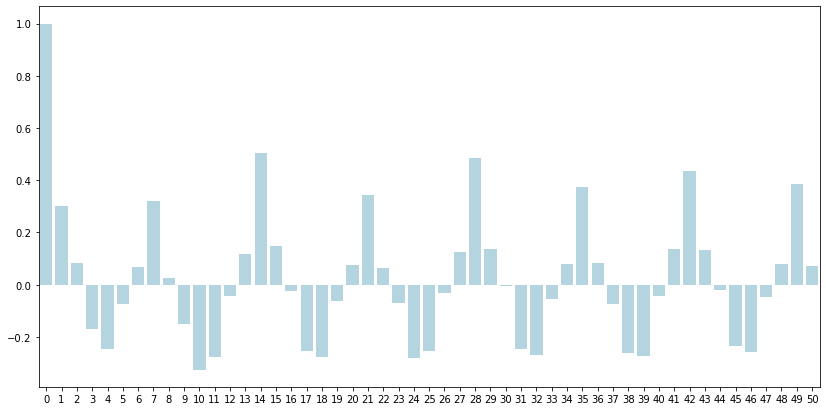

In [28]:
plt.figure(figsize=(14,7))
sns.barplot(x=list(range(0,51)),y=autocorrfunc,color='lightblue')

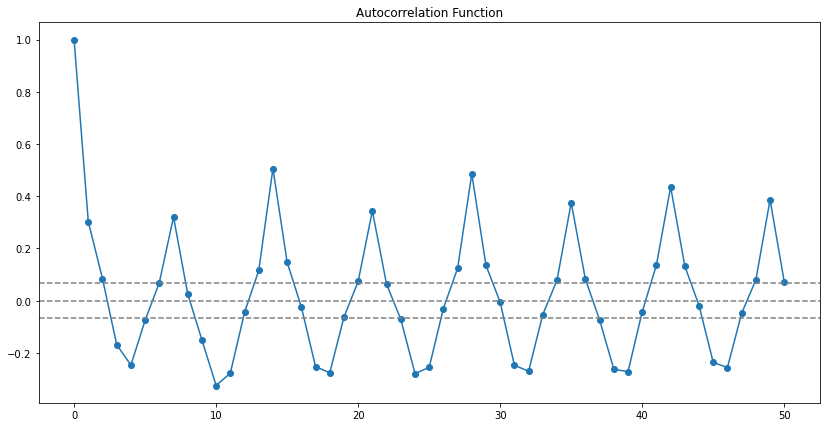

In [30]:
plt.figure(figsize=(14,7))
plt.plot(autocorrfunc,  marker='o') 
plt.axhline(y=0,linestyle='--',color='gray') 
plt.axhline(y=-1.96/np.sqrt(882),linestyle='--',color='gray') 
plt.axhline(y=1.96/np.sqrt(882),linestyle='--',color='gray') 
plt.title('Autocorrelation Function') 
plt.show() 

In [31]:
# dickey fuller, KPSS
from statsmodels.tsa.stattools import adfuller, kpss

In [32]:
def adf_test(timeseries):
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput=pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [33]:
adf_test(train[train.Course_ID==1]["User_Traffic"])

Results of Dickey-Fuller Test:
Test Statistic                -6.814058e+00
p-value                        2.080814e-09
#Lags Used                     2.100000e+01
Number of Observations Used    8.600000e+02
Critical Value (1%)           -3.437977e+00
Critical Value (5%)           -2.864907e+00
Critical Value (10%)          -2.568563e+00
dtype: float64


In [34]:
def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c')
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)

In [35]:
kpss_test(train[train.Course_ID==1]["User_Traffic"])

Results of KPSS Test:
Test Statistic            0.072358
p-value                   0.100000
Lags Used                21.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1843: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1876: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(warn_msg.format(direction="greater"), InterpolationWarning)


## Fitting Linear Model

In [141]:
lr=LinearRegression(normalize=True)
lr.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [143]:
y_train_pred=lr.predict(X_train)
y_val_pred=lr.predict(X_val)

In [144]:
1000*np.sqrt(mean_squared_error(y_train,y_train_pred))

174.6139972801859

In [145]:
1000*np.sqrt(mean_squared_error(y_val,y_val_pred))

309.2379920358871

In [146]:
lr.coef_

array([ 7.54603922e-06,  7.17176282e-03, -6.91828625e-03,  9.63880514e-02,
        2.31193095e-02,  1.53933669e-01, -1.42143108e-01,  7.48556237e-02,
        9.05218287e-01,  3.84867986e-01, -4.26562134e-04, -4.94774843e-02,
       -2.59676153e+00])

In [197]:
export_submission(y_test_pred,"Linear Regression Featuress")

## Grid Search For Linear Model

In [147]:
parameters={"normalize":["True","False"]}

In [171]:
search=GridSearchCV(LinearRegression(),param_grid=parameters,scoring='neg_mean_squared_error',cv=5)

In [172]:
search.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=LinearRegression(copy_X=True, fit_intercept=True,
                                        n_jobs=None, normalize=False),
             iid='deprecated', n_jobs=None,
             param_grid={'normalize': ['True', 'False']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [173]:
search.best_params_

{'normalize': 'True'}

In [174]:
search.best_score_

-0.06520298933937438

## Grid Search For Lasso Model

In [148]:
parameters={"normalize":["True","False"],
           "alpha":[0.0000001,0.000001,0.00001,0.0001,0.001,0.01,0.1]}

In [149]:
search=GridSearchCV(Lasso(random_state=10),parameters,scoring='neg_mean_squared_error',cv=5,n_jobs=-1,verbose=2)

In [150]:
search.fit(X_train,y_train)

Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   50.9s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:  4.3min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=10,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'alpha': [1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01,
                                   0.1],
                         'normalize': ['True', 'False']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=2)

In [151]:
search.best_params_

{'alpha': 1e-07, 'normalize': 'True'}

In [152]:
np.sqrt(-1*search.best_score_)

0.17638559246615532

In [154]:
lasso=Lasso(alpha=1e-07,normalize=True)
lasso.fit(X_train,y_train)

Lasso(alpha=1e-07, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=True, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [155]:
y_train_pred=lasso.predict(X_train)
y_val_pred=lasso.predict(X_val)

In [156]:
1000*np.sqrt(mean_squared_error(y_train,y_train_pred))

175.05504922579527

In [157]:
1000*np.sqrt(mean_squared_error(y_val,y_val_pred))

308.6264962712279

In [158]:
lasso.coef_

array([-1.48947301e-08,  4.51244553e-05, -1.72221193e-05,  9.65075669e-02,
        2.30145994e-02,  1.48223720e-01, -1.43841918e-01,  7.51544379e-02,
        9.06740729e-01,  3.84702035e-01,  1.22983786e-03,  4.40325648e-04,
       -0.00000000e+00])

In [582]:
X_train

,Course_ID,Course_Domain,Course_Type,Short_Promotion,Public_Holiday,Long_Promotion,Competition_Metric,Day_of_2_Weeks,Week_No,Year_No,Target_Course_ID,Group_Traffic
0,1,1,0,0,1,1,0.007,1,1,1,72.666667,9968.0
1,1,1,0,0,0,1,0.007,1,1,2,72.666667,9968.0
2,1,1,0,0,0,1,0.007,1,1,3,72.666667,9968.0
3,1,1,0,0,0,1,0.007,2,1,1,41.000000,6755.0
4,1,1,0,0,1,1,0.007,2,1,2,41.000000,6755.0
...,...,...,...,...,...,...,...,...,...,...,...,...
512082,600,3,2,1,0,1,0.070,14,4,3,144.000000,10164.0
512083,600,3,2,1,0,1,0.070,1,5,3,134.000000,9618.0
512084,600,3,2,1,0,1,0.070,2,5,3,130.000000,9807.0
512085,600,3,2,1,0,1,0.070,3,5,3,121.000000,9219.0


In [91]:
export_submission(y_test_pred,"Lasso Regression Engineered Features")

## Grid Search For Tree Model

In [159]:
tree=DecisionTreeRegressor()

In [160]:
tree.fit(X_train,y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [162]:
y_train_pred=tree.predict(X_train)
y_val_pred=tree.predict(X_val)

In [163]:
1000*np.sqrt(mean_squared_error(y_train,y_train_pred))

1.830350265476785e-14

In [164]:
1000*np.sqrt(mean_squared_error(y_val,y_val_pred))

304.4192083946222

In [587]:
export_submission(y_test_pred,"Tree Engineered Features")

In [165]:
tree.get_depth()

44

In [ ]:
path=tree.cost_complexity_pruning_path(X_train,y_train)

In [166]:
parameters={"max_depth":range(7,25)}

In [167]:
search=GridSearchCV(DecisionTreeRegressor(random_state=10),parameters,scoring='neg_mean_squared_error',cv=5,verbose=100)

In [ ]:
search.fit(X_train,y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] max_depth=7 .....................................................
[CV] ........................ max_depth=7, score=-0.024, total=   2.6s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.5s remaining:    0.0s
[CV] max_depth=7 .....................................................
[CV] ........................ max_depth=7, score=-0.028, total=   2.4s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.8s remaining:    0.0s
[CV] max_depth=7 .....................................................
[CV] ........................ max_depth=7, score=-0.035, total=   2.4s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    7.3s remaining:    0.0s
[CV] max_depth=7 .....................................................
[CV] ........................ max_depth=7, score=-0.037, total=   2.3s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapse

[CV] ....................... max_depth=14, score=-0.038, total=   4.3s
[Parallel(n_jobs=1)]: Done  37 out of  37 | elapsed:  1.9min remaining:    0.0s
[CV] max_depth=14 ....................................................
[CV] ....................... max_depth=14, score=-0.043, total=   4.0s
[Parallel(n_jobs=1)]: Done  38 out of  38 | elapsed:  2.0min remaining:    0.0s
[CV] max_depth=14 ....................................................
[CV] ....................... max_depth=14, score=-0.044, total=   4.0s
[Parallel(n_jobs=1)]: Done  39 out of  39 | elapsed:  2.1min remaining:    0.0s
[CV] max_depth=14 ....................................................
[CV] ....................... max_depth=14, score=-0.059, total=   3.9s
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:  2.1min remaining:    0.0s
[CV] max_depth=15 ....................................................
[CV] ....................... max_depth=15, score=-0.044, total=   4.2s
[Parallel(n_jobs=1)]: Done  41 out of  41

[CV] ....................... max_depth=21, score=-0.053, total=   5.1s
[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:  4.7min remaining:    0.0s
[CV] max_depth=21 ....................................................
[CV] ....................... max_depth=21, score=-0.069, total=   5.0s
[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:  4.8min remaining:    0.0s
[CV] max_depth=22 ....................................................
[CV] ....................... max_depth=22, score=-0.050, total=   5.1s
[Parallel(n_jobs=1)]: Done  76 out of  76 | elapsed:  4.9min remaining:    0.0s
[CV] max_depth=22 ....................................................
[CV] ....................... max_depth=22, score=-0.048, total=   5.1s
[Parallel(n_jobs=1)]: Done  77 out of  77 | elapsed:  5.0min remaining:    0.0s
[CV] max_depth=22 ....................................................
[CV] ....................... max_depth=22, score=-0.053, total=   5.1s
[Parallel(n_jobs=1)]: Done  78 out of  78

In [ ]:
search.best_params_

In [224]:
search.best_score_

-0.013210302124428008

In [225]:
tree=DecisionTreeRegressor(max_depth= 12)

In [226]:
tree.fit(X_train,y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=12,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [227]:
y_test_pred.min(),y_test_pred.max()

(2.4849066497880004, 6.1779441140506)

In [228]:
1000*np.sqrt(mean_squared_error(y_train,y_train_pred))

1.3277473750014732e-12

In [229]:
export_submission(y_test_pred,"Tree Max Depth Engineered Features")

## Random Forests

In [405]:
forest=RandomForestRegressor(max_features=None,n_estimators=400,n_jobs=8)

In [406]:
forest.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=None, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=400, n_jobs=8, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [407]:
y_train_pred=forest.predict(X_train)
y_test_pred=forest.predict(test)

In [408]:
1000*np.sqrt(mean_squared_error(y_train,y_train_pred))

107.22308899248416

In [409]:
export_submission(y_test_pred,"Forest Engineered Features")

In [114]:
parameters={"max_depth":range(2,20),'max_samples':[0.5,0.6,0.7,0.8]}

In [115]:
search=RandomizedSearchCV(RandomForestRegressor(random_state=10,max_features=None,verbose=2,n_estimators=150,n_jobs=-1),parameters,scoring='neg_mean_squared_error',cv=5,verbose=2,n_iter=20)

In [116]:
search.fit(X_train,y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed: 17.2min
[Parallel(n_jobs=6)]: Done 100 out of 100 | elapsed: 77.8min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features=None,
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=200, n_jobs=6,
                      

In [117]:
search.best_params_

{'max_samples': 0.8, 'max_depth': 7}

In [38]:
search.best_score_

-0.03500106369665605

In [412]:
tree=RandomForestRegressor(max_depth= 7, max_samples=0.8, verbose=2, n_jobs=-1)

In [413]:
tree.fit(X_train,y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100building tree 26 of 100

building tree 27 of 100
building tree 28 of 100


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    6.4s


building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100building tree 47 of 100

building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   26.6s finished


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=7, max_features='auto', max_leaf_nodes=None,
                      max_samples=0.8, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=2, warm_start=False)

In [414]:
y_train_pred=tree.predict(X_train)
y_test_pred=tree.predict(test)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished


In [415]:
1000*np.sqrt(mean_squared_error(y_train,y_train_pred))

131.3696498980016

In [416]:
export_submission(y_test_pred,"Random Forest Tuned Engineered Features")

## LightGBM

In [430]:
regressor=LGBMRegressor()

In [431]:
regressor.fit(X_train,y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [434]:
regressor.max_bin

AttributeError: 'LGBMRegressor' object has no attribute 'max_bin'

In [419]:
y_train_pred=regressor.predict(X_train)
y_test_pred=regressor.predict(test)

In [420]:
1000*np.sqrt(mean_squared_error(y_train,y_train_pred))

117.33328243727972

In [421]:
export_submission(y_test_pred,"LGBM Default Engineered Features")

In [427]:
parameters={'max_depth':range(2,10),
           }

In [428]:
search=RandomizedSearchCV(LGBMRegressor(n_estimators=200,random_state=10),parameters,scoring='neg_mean_squared_error',n_jobs=-1,cv=5,verbose=2,n_iter=10)

In [429]:
search.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   39.3s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   39.3s
[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:   39.3s
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:   39.3s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   39.3s
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:   39.3s
[Parallel(n_jobs=-1)]: Done  23 tasks      | elapsed:   39.3s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   39.3s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   39.3s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   39.3s
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:   39.3s
[Parallel(n_jobs=-1)]: Done  38 out of  40 | elapsed:   39.3s remaining:    2.0s


KeyboardInterrupt: 

In [174]:
search.best_params_

{'learning_rate': 0.017}

In [175]:
search.best_score_

-0.05427853762690869

In [170]:
search.cv_results_

AttributeError: 'RandomizedSearchCV' object has no attribute 'cv_results_'

In [437]:
lightgbm = LGBMRegressor( task= 'train',
          boosting_type= 'gbdt',
          objective= 'regression',
          metric= 'l2',
          num_leaves= 300,
          learning_rate= 0.32,
          feature_fraction= 0.9,
          bagging_fraction= .9,
          bagging_freq= 70,
          verbose= 100)

In [453]:
booster=LGBMRegressor( task= 'train',
          boosting_type= 'gbdt',
          objective= 'regression',
          metric= 'l1',
          num_leaves= 300,
          learning_rate= 0.32,  
          bagging_fraction= .9,
          bagging_freq= 70,
          verbose= 100)

In [454]:
booster.fit(X_train,y_train)

[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=70, subsample_freq=0 will be ignored. Current value: bagging_freq=70
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=70, subsample_freq=0 will be ignored. Current value: bagging_freq=70
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.793997
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.239815
[LightGBM] [Debug] init for col-wise cost 0.022439 seconds, init for row-wise cost 0.042293 seconds
[LightGBM] [Debug] col-wise cost 0.009825 seconds, row-wise cost 0.003463 seconds
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035727 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `

[LightGBM] [Debug] Trained a tree with leaves = 300 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 300 and max_depth = 24


LGBMRegressor(bagging_fraction=0.9, bagging_freq=70, boosting_type='gbdt',
              class_weight=None, colsample_bytree=1.0, importance_type='split',
              learning_rate=0.32, max_depth=-1, metric='l1',
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=300,
              objective='regression', random_state=None, reg_alpha=0.0,
              reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0, task='train',
              verbose=100)

In [455]:
y_train_pred=booster.predict(X_train)
y_test_pred=booster.predict(test)

In [456]:
1000*np.sqrt(mean_squared_error(y_train,y_train_pred))

109.82900129001581

In [458]:
export_submission(y_test_pred,"LGBM Optimized Engineered Features")

## KNN

In [ ]:
scaler=MinMaxScaler()
X_train=scaler.fit_transform(X_train)


In [25]:
knn=KNeighborsRegressor(n_neighbors= 17,n_jobs=-1)

In [ ]:
knn.fit(X_train,y_train)

In [138]:
y_train_pred=forest.predict(X_train)
y_test_pred=forest.predict(test)

In [139]:
1000*np.sqrt(mean_squared_error(y_train,y_train_pred))

216.13655175210727

In [140]:
export_submission(y_test_pred,"KNN 17 Engineered Features")

In [131]:
parameters={'n_neighbors':range(1,50,1)}

In [132]:
search=GridSearchCV(KNeighborsRegressor(n_jobs=6),parameters,scoring='neg_mean_squared_error',cv=5,verbose=2,n_jobs=6)

In [133]:
search.fit(X_train,y_train)

Fitting 5 folds for each of 49 candidates, totalling 245 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:   30.4s
[Parallel(n_jobs=10)]: Done 142 tasks      | elapsed:  3.2min
[Parallel(n_jobs=10)]: Done 245 out of 245 | elapsed:  5.7min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30,
                                           metric='minkowski',
                                           metric_params=None, n_jobs=None,
                                           n_neighbors=5, p=2,
                                           weights='uniform'),
             iid='deprecated', n_jobs=10,
             param_grid={'n_neighbors': range(1, 50)}, pre_dispatch='2*n_jobs',
             refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=2)

In [134]:
search.best_params_

{'n_neighbors': 17}

In [135]:
search.best_score_

-0.06775012845127092

## Catboost

In [164]:
boost=CatBoostRegressor(learning_rate=0.01)

In [165]:
boost.fit(X_train,y_train)

0:	learn: 0.4576319	total: 47.7ms	remaining: 47.6s
1:	learn: 0.4539557	total: 92.2ms	remaining: 46s
2:	learn: 0.4503334	total: 140ms	remaining: 46.6s
3:	learn: 0.4467243	total: 192ms	remaining: 47.7s
4:	learn: 0.4431456	total: 247ms	remaining: 49.2s
5:	learn: 0.4395896	total: 308ms	remaining: 51s
6:	learn: 0.4360925	total: 358ms	remaining: 50.8s
7:	learn: 0.4326444	total: 409ms	remaining: 50.7s
8:	learn: 0.4292267	total: 462ms	remaining: 50.8s
9:	learn: 0.4258651	total: 512ms	remaining: 50.7s
10:	learn: 0.4225387	total: 563ms	remaining: 50.6s
11:	learn: 0.4192125	total: 614ms	remaining: 50.5s
12:	learn: 0.4159608	total: 662ms	remaining: 50.3s
13:	learn: 0.4127267	total: 710ms	remaining: 50s
14:	learn: 0.4095260	total: 761ms	remaining: 50s
15:	learn: 0.4063475	total: 813ms	remaining: 50s
16:	learn: 0.4032326	total: 858ms	remaining: 49.6s
17:	learn: 0.4001225	total: 906ms	remaining: 49.4s
18:	learn: 0.3970596	total: 952ms	remaining: 49.1s
19:	learn: 0.3940225	total: 1s	remaining: 49.2s
2

164:	learn: 0.1822514	total: 8.04s	remaining: 40.7s
165:	learn: 0.1817667	total: 8.09s	remaining: 40.6s
166:	learn: 0.1812595	total: 8.14s	remaining: 40.6s
167:	learn: 0.1807526	total: 8.19s	remaining: 40.5s
168:	learn: 0.1803009	total: 8.24s	remaining: 40.5s
169:	learn: 0.1798649	total: 8.29s	remaining: 40.5s
170:	learn: 0.1794144	total: 8.34s	remaining: 40.4s
171:	learn: 0.1789758	total: 8.38s	remaining: 40.4s
172:	learn: 0.1785404	total: 8.43s	remaining: 40.3s
173:	learn: 0.1781191	total: 8.48s	remaining: 40.3s
174:	learn: 0.1777024	total: 8.54s	remaining: 40.2s
175:	learn: 0.1772936	total: 8.58s	remaining: 40.2s
176:	learn: 0.1768856	total: 8.63s	remaining: 40.1s
177:	learn: 0.1764968	total: 8.68s	remaining: 40.1s
178:	learn: 0.1760992	total: 8.72s	remaining: 40s
179:	learn: 0.1757170	total: 8.77s	remaining: 39.9s
180:	learn: 0.1753414	total: 8.81s	remaining: 39.9s
181:	learn: 0.1749706	total: 8.86s	remaining: 39.8s
182:	learn: 0.1746019	total: 8.91s	remaining: 39.8s
183:	learn: 0.

327:	learn: 0.1503545	total: 15.7s	remaining: 32.1s
328:	learn: 0.1503109	total: 15.7s	remaining: 32.1s
329:	learn: 0.1502683	total: 15.8s	remaining: 32s
330:	learn: 0.1501448	total: 15.8s	remaining: 31.9s
331:	learn: 0.1498822	total: 15.9s	remaining: 31.9s
332:	learn: 0.1497633	total: 15.9s	remaining: 31.9s
333:	learn: 0.1497168	total: 15.9s	remaining: 31.8s
334:	learn: 0.1496026	total: 16s	remaining: 31.7s
335:	learn: 0.1495647	total: 16s	remaining: 31.7s
336:	learn: 0.1494886	total: 16.1s	remaining: 31.6s
337:	learn: 0.1494545	total: 16.1s	remaining: 31.6s
338:	learn: 0.1493424	total: 16.2s	remaining: 31.5s
339:	learn: 0.1492453	total: 16.2s	remaining: 31.5s
340:	learn: 0.1491364	total: 16.3s	remaining: 31.4s
341:	learn: 0.1491015	total: 16.3s	remaining: 31.4s
342:	learn: 0.1488331	total: 16.4s	remaining: 31.3s
343:	learn: 0.1486446	total: 16.4s	remaining: 31.3s
344:	learn: 0.1486044	total: 16.5s	remaining: 31.2s
345:	learn: 0.1484741	total: 16.5s	remaining: 31.2s
346:	learn: 0.1482

486:	learn: 0.1323613	total: 23.4s	remaining: 24.6s
487:	learn: 0.1322527	total: 23.4s	remaining: 24.6s
488:	learn: 0.1321548	total: 23.5s	remaining: 24.5s
489:	learn: 0.1320376	total: 23.5s	remaining: 24.5s
490:	learn: 0.1318594	total: 23.6s	remaining: 24.4s
491:	learn: 0.1317876	total: 23.6s	remaining: 24.4s
492:	learn: 0.1316942	total: 23.7s	remaining: 24.3s
493:	learn: 0.1316843	total: 23.7s	remaining: 24.3s
494:	learn: 0.1315194	total: 23.7s	remaining: 24.2s
495:	learn: 0.1314596	total: 23.8s	remaining: 24.2s
496:	learn: 0.1312742	total: 23.8s	remaining: 24.1s
497:	learn: 0.1312206	total: 23.9s	remaining: 24.1s
498:	learn: 0.1311571	total: 23.9s	remaining: 24s
499:	learn: 0.1310546	total: 24s	remaining: 24s
500:	learn: 0.1308477	total: 24s	remaining: 23.9s
501:	learn: 0.1307316	total: 24.1s	remaining: 23.9s
502:	learn: 0.1306793	total: 24.1s	remaining: 23.8s
503:	learn: 0.1305269	total: 24.2s	remaining: 23.8s
504:	learn: 0.1304144	total: 24.2s	remaining: 23.8s
505:	learn: 0.130268

647:	learn: 0.1218521	total: 31.1s	remaining: 16.9s
648:	learn: 0.1217810	total: 31.2s	remaining: 16.9s
649:	learn: 0.1217686	total: 31.2s	remaining: 16.8s
650:	learn: 0.1217404	total: 31.3s	remaining: 16.8s
651:	learn: 0.1216440	total: 31.3s	remaining: 16.7s
652:	learn: 0.1216048	total: 31.4s	remaining: 16.7s
653:	learn: 0.1215621	total: 31.4s	remaining: 16.6s
654:	learn: 0.1215537	total: 31.5s	remaining: 16.6s
655:	learn: 0.1215241	total: 31.5s	remaining: 16.5s
656:	learn: 0.1214678	total: 31.6s	remaining: 16.5s
657:	learn: 0.1214454	total: 31.6s	remaining: 16.4s
658:	learn: 0.1214067	total: 31.6s	remaining: 16.4s
659:	learn: 0.1213583	total: 31.7s	remaining: 16.3s
660:	learn: 0.1212655	total: 31.7s	remaining: 16.3s
661:	learn: 0.1211959	total: 31.8s	remaining: 16.2s
662:	learn: 0.1211763	total: 31.8s	remaining: 16.2s
663:	learn: 0.1211336	total: 31.9s	remaining: 16.1s
664:	learn: 0.1211217	total: 31.9s	remaining: 16.1s
665:	learn: 0.1210817	total: 32s	remaining: 16s
666:	learn: 0.12

809:	learn: 0.1159663	total: 39s	remaining: 9.14s
810:	learn: 0.1159227	total: 39s	remaining: 9.09s
811:	learn: 0.1158907	total: 39.1s	remaining: 9.04s
812:	learn: 0.1158696	total: 39.1s	remaining: 8.99s
813:	learn: 0.1158394	total: 39.2s	remaining: 8.95s
814:	learn: 0.1158055	total: 39.2s	remaining: 8.9s
815:	learn: 0.1157850	total: 39.3s	remaining: 8.85s
816:	learn: 0.1157539	total: 39.3s	remaining: 8.81s
817:	learn: 0.1157124	total: 39.4s	remaining: 8.76s
818:	learn: 0.1156405	total: 39.4s	remaining: 8.71s
819:	learn: 0.1156260	total: 39.5s	remaining: 8.66s
820:	learn: 0.1155959	total: 39.5s	remaining: 8.62s
821:	learn: 0.1155875	total: 39.6s	remaining: 8.57s
822:	learn: 0.1155578	total: 39.6s	remaining: 8.52s
823:	learn: 0.1155322	total: 39.7s	remaining: 8.48s
824:	learn: 0.1154955	total: 39.7s	remaining: 8.43s
825:	learn: 0.1154749	total: 39.8s	remaining: 8.38s
826:	learn: 0.1154105	total: 39.8s	remaining: 8.33s
827:	learn: 0.1153872	total: 39.9s	remaining: 8.29s
828:	learn: 0.115

969:	learn: 0.1118658	total: 47.3s	remaining: 1.46s
970:	learn: 0.1118504	total: 47.4s	remaining: 1.41s
971:	learn: 0.1118234	total: 47.4s	remaining: 1.36s
972:	learn: 0.1117969	total: 47.5s	remaining: 1.32s
973:	learn: 0.1117881	total: 47.5s	remaining: 1.27s
974:	learn: 0.1117657	total: 47.6s	remaining: 1.22s
975:	learn: 0.1117534	total: 47.6s	remaining: 1.17s
976:	learn: 0.1117357	total: 47.7s	remaining: 1.12s
977:	learn: 0.1117172	total: 47.7s	remaining: 1.07s
978:	learn: 0.1117103	total: 47.8s	remaining: 1.02s
979:	learn: 0.1116738	total: 47.8s	remaining: 976ms
980:	learn: 0.1116605	total: 47.9s	remaining: 927ms
981:	learn: 0.1116368	total: 47.9s	remaining: 878ms
982:	learn: 0.1116137	total: 48s	remaining: 829ms
983:	learn: 0.1115968	total: 48s	remaining: 781ms
984:	learn: 0.1115851	total: 48.1s	remaining: 732ms
985:	learn: 0.1115591	total: 48.1s	remaining: 683ms
986:	learn: 0.1115506	total: 48.2s	remaining: 634ms
987:	learn: 0.1115461	total: 48.2s	remaining: 585ms
988:	learn: 0.11

In [166]:
y_train_pred=boost.predict(X_train)
y_test_pred=boost.predict(test)

In [167]:
1000*np.sqrt(mean_squared_error(y_train,y_train_pred))

111.33271193869358

In [168]:
export_submission(y_test_pred,"Boost Cat 0.01")

In [46]:
parameters={'learning_rate':np.arange(0.01,0.1,0.01)}

In [47]:
search=GridSearchCV(CatBoostRegressor(),parameters,scoring='neg_mean_squared_error',cv=5,verbose=2,n_jobs=10)

In [48]:
search.fit(X_train,y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed: 14.9min
[Parallel(n_jobs=10)]: Done  45 out of  45 | elapsed: 23.2min finished


0:	learn: 0.4581315	total: 41.1ms	remaining: 41s
1:	learn: 0.4549662	total: 81.9ms	remaining: 40.9s
2:	learn: 0.4518408	total: 124ms	remaining: 41.3s
3:	learn: 0.4487626	total: 165ms	remaining: 41.1s
4:	learn: 0.4457285	total: 202ms	remaining: 40.3s
5:	learn: 0.4427298	total: 239ms	remaining: 39.7s
6:	learn: 0.4397585	total: 279ms	remaining: 39.6s
7:	learn: 0.4368247	total: 320ms	remaining: 39.6s
8:	learn: 0.4339013	total: 358ms	remaining: 39.4s
9:	learn: 0.4310652	total: 400ms	remaining: 39.6s
10:	learn: 0.4282187	total: 440ms	remaining: 39.6s
11:	learn: 0.4254297	total: 484ms	remaining: 39.8s
12:	learn: 0.4226888	total: 523ms	remaining: 39.7s
13:	learn: 0.4199831	total: 563ms	remaining: 39.7s
14:	learn: 0.4173058	total: 604ms	remaining: 39.7s
15:	learn: 0.4146414	total: 642ms	remaining: 39.5s
16:	learn: 0.4120248	total: 685ms	remaining: 39.6s
17:	learn: 0.4094287	total: 725ms	remaining: 39.5s
18:	learn: 0.4068415	total: 763ms	remaining: 39.4s
19:	learn: 0.4043302	total: 801ms	remaini

166:	learn: 0.2483624	total: 6.48s	remaining: 32.3s
167:	learn: 0.2480952	total: 6.51s	remaining: 32.2s
168:	learn: 0.2478364	total: 6.55s	remaining: 32.2s
169:	learn: 0.2475800	total: 6.58s	remaining: 32.2s
170:	learn: 0.2473318	total: 6.62s	remaining: 32.1s
171:	learn: 0.2470841	total: 6.66s	remaining: 32.1s
172:	learn: 0.2468403	total: 6.71s	remaining: 32.1s
173:	learn: 0.2465988	total: 6.74s	remaining: 32s
174:	learn: 0.2463623	total: 6.78s	remaining: 32s
175:	learn: 0.2461301	total: 6.82s	remaining: 31.9s
176:	learn: 0.2459005	total: 6.86s	remaining: 31.9s
177:	learn: 0.2456802	total: 6.9s	remaining: 31.8s
178:	learn: 0.2454685	total: 6.94s	remaining: 31.8s
179:	learn: 0.2452494	total: 6.97s	remaining: 31.8s
180:	learn: 0.2450387	total: 7.01s	remaining: 31.7s
181:	learn: 0.2448321	total: 7.05s	remaining: 31.7s
182:	learn: 0.2446227	total: 7.08s	remaining: 31.6s
183:	learn: 0.2444227	total: 7.11s	remaining: 31.6s
184:	learn: 0.2442284	total: 7.15s	remaining: 31.5s
185:	learn: 0.244

326:	learn: 0.2338696	total: 12.2s	remaining: 25.1s
327:	learn: 0.2338512	total: 12.2s	remaining: 25.1s
328:	learn: 0.2338335	total: 12.3s	remaining: 25s
329:	learn: 0.2338171	total: 12.3s	remaining: 25s
330:	learn: 0.2338011	total: 12.3s	remaining: 24.9s
331:	learn: 0.2337844	total: 12.4s	remaining: 24.9s
332:	learn: 0.2337676	total: 12.4s	remaining: 24.9s
333:	learn: 0.2337504	total: 12.5s	remaining: 24.8s
334:	learn: 0.2337341	total: 12.5s	remaining: 24.8s
335:	learn: 0.2337202	total: 12.5s	remaining: 24.7s
336:	learn: 0.2337040	total: 12.6s	remaining: 24.7s
337:	learn: 0.2336880	total: 12.6s	remaining: 24.7s
338:	learn: 0.2336744	total: 12.6s	remaining: 24.6s
339:	learn: 0.2336622	total: 12.7s	remaining: 24.6s
340:	learn: 0.2336474	total: 12.7s	remaining: 24.6s
341:	learn: 0.2336335	total: 12.8s	remaining: 24.5s
342:	learn: 0.2336195	total: 12.8s	remaining: 24.5s
343:	learn: 0.2336064	total: 12.8s	remaining: 24.5s
344:	learn: 0.2335939	total: 12.9s	remaining: 24.4s
345:	learn: 0.23

487:	learn: 0.2327487	total: 18s	remaining: 18.8s
488:	learn: 0.2327467	total: 18s	remaining: 18.8s
489:	learn: 0.2327445	total: 18s	remaining: 18.8s
490:	learn: 0.2327426	total: 18.1s	remaining: 18.7s
491:	learn: 0.2327380	total: 18.1s	remaining: 18.7s
492:	learn: 0.2327347	total: 18.1s	remaining: 18.7s
493:	learn: 0.2327317	total: 18.2s	remaining: 18.6s
494:	learn: 0.2327275	total: 18.2s	remaining: 18.6s
495:	learn: 0.2327241	total: 18.3s	remaining: 18.6s
496:	learn: 0.2327225	total: 18.3s	remaining: 18.5s
497:	learn: 0.2327200	total: 18.3s	remaining: 18.5s
498:	learn: 0.2327153	total: 18.4s	remaining: 18.4s
499:	learn: 0.2327138	total: 18.4s	remaining: 18.4s
500:	learn: 0.2327112	total: 18.4s	remaining: 18.4s
501:	learn: 0.2327083	total: 18.5s	remaining: 18.3s
502:	learn: 0.2327068	total: 18.5s	remaining: 18.3s
503:	learn: 0.2327031	total: 18.5s	remaining: 18.3s
504:	learn: 0.2327013	total: 18.6s	remaining: 18.2s
505:	learn: 0.2326992	total: 18.6s	remaining: 18.2s
506:	learn: 0.2326

649:	learn: 0.2324147	total: 23.8s	remaining: 12.8s
650:	learn: 0.2324136	total: 23.8s	remaining: 12.8s
651:	learn: 0.2324114	total: 23.9s	remaining: 12.8s
652:	learn: 0.2324095	total: 23.9s	remaining: 12.7s
653:	learn: 0.2324072	total: 24s	remaining: 12.7s
654:	learn: 0.2324057	total: 24s	remaining: 12.6s
655:	learn: 0.2324042	total: 24s	remaining: 12.6s
656:	learn: 0.2324024	total: 24.1s	remaining: 12.6s
657:	learn: 0.2324017	total: 24.1s	remaining: 12.5s
658:	learn: 0.2324000	total: 24.1s	remaining: 12.5s
659:	learn: 0.2323998	total: 24.2s	remaining: 12.5s
660:	learn: 0.2323984	total: 24.2s	remaining: 12.4s
661:	learn: 0.2323956	total: 24.3s	remaining: 12.4s
662:	learn: 0.2323941	total: 24.3s	remaining: 12.3s
663:	learn: 0.2323929	total: 24.3s	remaining: 12.3s
664:	learn: 0.2323917	total: 24.4s	remaining: 12.3s
665:	learn: 0.2323905	total: 24.4s	remaining: 12.2s
666:	learn: 0.2323888	total: 24.4s	remaining: 12.2s
667:	learn: 0.2323866	total: 24.5s	remaining: 12.2s
668:	learn: 0.2323

812:	learn: 0.2321869	total: 29.9s	remaining: 6.88s
813:	learn: 0.2321862	total: 29.9s	remaining: 6.84s
814:	learn: 0.2321854	total: 30s	remaining: 6.8s
815:	learn: 0.2321831	total: 30s	remaining: 6.76s
816:	learn: 0.2321816	total: 30s	remaining: 6.73s
817:	learn: 0.2321802	total: 30.1s	remaining: 6.69s
818:	learn: 0.2321795	total: 30.1s	remaining: 6.65s
819:	learn: 0.2321781	total: 30.1s	remaining: 6.62s
820:	learn: 0.2321767	total: 30.2s	remaining: 6.58s
821:	learn: 0.2321757	total: 30.2s	remaining: 6.54s
822:	learn: 0.2321742	total: 30.2s	remaining: 6.5s
823:	learn: 0.2321723	total: 30.3s	remaining: 6.47s
824:	learn: 0.2321708	total: 30.3s	remaining: 6.43s
825:	learn: 0.2321698	total: 30.3s	remaining: 6.39s
826:	learn: 0.2321691	total: 30.4s	remaining: 6.36s
827:	learn: 0.2321681	total: 30.4s	remaining: 6.32s
828:	learn: 0.2321668	total: 30.4s	remaining: 6.28s
829:	learn: 0.2321664	total: 30.5s	remaining: 6.24s
830:	learn: 0.2321656	total: 30.5s	remaining: 6.21s
831:	learn: 0.232164

973:	learn: 0.2320068	total: 35.6s	remaining: 951ms
974:	learn: 0.2320050	total: 35.7s	remaining: 914ms
975:	learn: 0.2320036	total: 35.7s	remaining: 878ms
976:	learn: 0.2320015	total: 35.7s	remaining: 841ms
977:	learn: 0.2319988	total: 35.8s	remaining: 805ms
978:	learn: 0.2319965	total: 35.8s	remaining: 768ms
979:	learn: 0.2319962	total: 35.8s	remaining: 731ms
980:	learn: 0.2319943	total: 35.9s	remaining: 695ms
981:	learn: 0.2319933	total: 35.9s	remaining: 658ms
982:	learn: 0.2319918	total: 35.9s	remaining: 621ms
983:	learn: 0.2319915	total: 36s	remaining: 585ms
984:	learn: 0.2319908	total: 36s	remaining: 548ms
985:	learn: 0.2319897	total: 36.1s	remaining: 512ms
986:	learn: 0.2319895	total: 36.1s	remaining: 475ms
987:	learn: 0.2319894	total: 36.1s	remaining: 439ms
988:	learn: 0.2319876	total: 36.1s	remaining: 402ms
989:	learn: 0.2319864	total: 36.2s	remaining: 366ms
990:	learn: 0.2319854	total: 36.2s	remaining: 329ms
991:	learn: 0.2319847	total: 36.3s	remaining: 293ms
992:	learn: 0.23

GridSearchCV(cv=5, error_score=nan,
             estimator=<catboost.core.CatBoostRegressor object at 0x0000020897FE7EC8>,
             iid='deprecated', n_jobs=10,
             param_grid={'learning_rate': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=2)

In [49]:
search.best_params_

{'learning_rate': 0.01}

In [50]:
search.best_score_

-0.05416058943637192

## XGBoost

In [169]:
boost=XGBRegressor()

In [170]:
boost.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [171]:
test

,Course_ID,Course_Domain,Course_Type,Short_Promotion,Public_Holiday,Long_Promotion,Competition_Metric,Day_of_2_Weeks,Week_No,Year_No,Target_Course_ID,Group_Traffic
0,1,1,0,1,0,1,0.007,1,23,3,107.0,14175.0
1,1,1,0,1,0,1,0.007,2,23,3,123.0,17850.0
2,1,1,0,1,0,1,0.007,3,23,3,96.5,12988.5
3,1,1,0,1,0,1,0.007,4,23,3,93.0,12484.5
4,1,1,0,0,0,1,0.007,5,23,3,46.0,7245.0
...,...,...,...,...,...,...,...,...,...,...,...,...
35995,600,3,2,1,0,1,0.070,14,30,3,149.0,10993.5
35996,600,3,2,1,0,1,0.070,1,31,3,129.0,9796.5
35997,600,3,2,1,0,1,0.070,2,31,3,125.0,9576.0
35998,600,3,2,1,0,1,0.070,3,31,3,124.0,9124.5


In [172]:
y_train_pred=boost.predict(X_train)
y_test_pred=boost.predict(test)

In [173]:
1000*np.sqrt(mean_squared_error(y_train,y_train_pred))

85.66977124247153

In [174]:
y_test_pred

array([4.758759 , 4.9058685, 4.680691 , ..., 4.903514 , 4.936084 ,
       4.9767456], dtype=float32)

In [175]:
export_submission(y_test_pred,"XGBoost")

In [258]:
parameters={'base_score':[0.2,0.3,0.4,0.5,0.6,0.7,0.8],
           'max_depth':[2,3,4,5,6,7,8,9,10,11,12],
           'subsample':[0.5,0.6,0.7,0.8,0.9,1.0],
            'learning_rate':[0.1,0.2,0.3,0.4,0.5,0.6]
            }

In [259]:
search=RandomizedSearchCV(XGBRegressor(),parameters,scoring='neg_mean_squared_error',cv=5,verbose=100,n_iter=10)

In [260]:
search.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] subsample=0.7, max_depth=9, learning_rate=0.3, base_score=0.3 ...
[CV]  subsample=0.7, max_depth=9, learning_rate=0.3, base_score=0.3, score=-0.011, total=  26.4s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   26.3s remaining:    0.0s
[CV] subsample=0.7, max_depth=9, learning_rate=0.3, base_score=0.3 ...
[CV]  subsample=0.7, max_depth=9, learning_rate=0.3, base_score=0.3, score=-0.008, total=  26.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   52.3s remaining:    0.0s
[CV] subsample=0.7, max_depth=9, learning_rate=0.3, base_score=0.3 ...
[CV]  subsample=0.7, max_depth=9, learning_rate=0.3, base_score=0.3, score=-0.009, total=  26.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.3min remaining:    0.0s
[CV] subsample=0.7, max_depth=9, learning_rate=0.3, base_score=0.3 ...
[CV]  subsample=0.7, max_depth=9, learning_

[CV]  subsample=1.0, max_depth=11, learning_rate=0.4, base_score=0.2, score=-0.009, total=  28.5s
[Parallel(n_jobs=1)]: Done  34 out of  34 | elapsed: 12.6min remaining:    0.0s
[CV] subsample=1.0, max_depth=11, learning_rate=0.4, base_score=0.2 ..
[CV]  subsample=1.0, max_depth=11, learning_rate=0.4, base_score=0.2, score=-0.010, total=  27.8s
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed: 13.0min remaining:    0.0s
[CV] subsample=0.9, max_depth=12, learning_rate=0.5, base_score=0.3 ..
[CV]  subsample=0.9, max_depth=12, learning_rate=0.5, base_score=0.3, score=-0.012, total=  35.7s
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed: 13.6min remaining:    0.0s
[CV] subsample=0.9, max_depth=12, learning_rate=0.5, base_score=0.3 ..
[CV]  subsample=0.9, max_depth=12, learning_rate=0.5, base_score=0.3, score=-0.009, total=  33.6s
[Parallel(n_jobs=1)]: Done  37 out of  37 | elapsed: 14.2min remaining:    0.0s
[CV] subsample=0.9, max_depth=12, learning_rate=0.5, base_score=0.3 ..
[CV]

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_...
                                          verbosity=None),
                   iid='deprecated', n_iter=10, n_jobs=None,
                   param_distributions={'base_score': [0.2, 0.3, 0.4, 

In [261]:
search.best_params_

{'subsample': 0.7, 'max_depth': 9, 'learning_rate': 0.3, 'base_score': 0.3}

In [262]:
search.best_score_

-0.008966443416140548

In [263]:
boost=XGBRegressor(subsample=0.7,max_depth=9,learning_rate=0.3,base_score=0.3)

In [264]:
boost.fit(X_train,y_train)

XGBRegressor(base_score=0.3, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.3, max_delta_step=0, max_depth=9,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=0.7,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [265]:
y_train_pred=boost.predict(X_train)
y_test_pred=boost.predict(test)

In [266]:
1000*np.sqrt(mean_squared_error(y_train,y_train_pred))

68.95229770074857

In [267]:
export_submission(y_test_pred,"XGBoost More Improved")

## Ensembling

In [491]:
data1=pd.read_csv("Compiled New/Catboost.csv")
data2=pd.read_csv("Compiled New/LGBM.csv")
data3=pd.read_csv("Compiled New/Random Forest.csv")
data4=pd.read_csv("Compiled New/XGB.csv")

In [492]:
aa=(data1["Sales"]+data2["Sales"]+data3["Sales"]+data4["Sales"])/4

In [493]:
def export_submission(predictions,filename="Sample.csv"):
    
    ss=sample_sub.copy()
    ss["Sales"]=predictions
    ss.to_csv(f"{filename}.csv",index=False)

In [494]:
export_submission(aa,"Simple_Mean_All")

In [495]:
pd.read_csv("Simple_Mean_All.csv")

,ID,Sales
0,883,106.474328
1,884,122.680358
2,885,96.400178
3,886,93.214625
4,887,47.277525
...,...,...
35995,548083,147.101124
35996,548084,126.964361
35997,548085,122.921234
35998,548086,121.567769
